<h2><center>Neural Language Model for Text Generation</center></h2>

<h2><center>Introduction</center></h2>

<h3> About the Dataset : </h3>
The Republic is the classical Greek philosopher Plato’s most famous work. It is structured as a dialog (e.g. conversation) on the topic of order and justice within a city state The entire text is available for free in the public domain.
<br><br>
<h3>Language Model Design : </h3>

In this notebook, we will develop a model of the text that we can then use to generate new sequences of text. The language model will be statistical and will predict the probability of each word given an input sequence of text. The predicted word will be fed in as input to in turn generate the next word. A key design decision is how long the input sequences should be. They need to be long enough to allow the model to learn the context for the words to predict. This input length will also define the length of seed text used to generate new sequences when we use the model.
There is no correct answer. With enough time and resources, we could explore the ability of the model to learn with differently sized input sequences. Instead, we will pick a length of 50 words for the length of the input sequences, somewhat arbitrarily. We could process the data so that the model only ever deals with self-contained sentences and pad or truncate the text to meet this requirement for each input sequence.

<h3><center>Importing Libraries</center></h3>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import re
import string
from random import randint

from keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, Dense, Dropout, SimpleRNN, GRU

from keras.utils.vis_utils import plot_model

<h3><center>Loading File

In [ ]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
# in_file = '../input/the-republic-by-plato/pg1497.txt'
# in_file = 'pg1497.txt'
in_file = 'pg1497.txt'
doc = load_doc(in_file)
print(doc[:1000])

﻿The Project Gutenberg eBook of The Republic, by Plato

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: The Republic

Author: Plato

Translator: B. Jowett

Release Date: October, 1998 [eBook #1497]
[Most recently updated: September 11, 2021]

Language: English


Produced by: Sue Asscher and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK THE REPUBLIC ***




THE REPUBLIC

By Plato

Translated by Benjamin Jowett

Note: See also “The Republic” by Plato, Jowett, eBook #150


Contents

 INTRODUCTION AND ANALYSIS.
 THE REPUBLIC.
 PERSONS OF THE DIALOGUE.
 BOOK I.
 BOOK II.
 BOOK III.
 BOO

<h3><center>Extracting only Books from the doc

In [ ]:
[m.start() for m in re.finditer('BOOK I\.', doc)]

[967, 38188, 553671]

In [ ]:
[m.start() for m in re.finditer('End of', doc)]

[]

In [ ]:
books = doc[553615:1195644]

print(books[:300])

ameless person, who are
introduced in the Timaeus.




 BOOK I.


I went down yesterday to the Piraeus with Glaucon the son of Ariston,
that I might offer up my prayers to the goddess (Bendis, the Thracian
Artemis.); and also because I wanted to see in what manner they would
celebrate the festival, 


<h3><center>Cleaning Text

In [ ]:
def remove_punctuation(text):
    PUNCT_TO_REMOVE = string.punctuation
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [ ]:
cleaned_book = remove_punctuation(books)

tokens = cleaned_book.split()
tokens = [word for word in tokens if word.isalpha()]
tokens = [word.lower() for word in tokens]

print('Tokens :\n',tokens[:10])
print('No of Tokens : ',len(tokens))
print('Unique Tokens : ',len(set(tokens)))

Tokens :
 ['hold', 'of', 'me', 'by', 'the', 'cloak', 'behind', 'and', 'said', 'polemarchus']
No of Tokens :  118086
Unique Tokens :  7830


In [ ]:
sequences = list()
for i in range(0,len(tokens),51):
    seq = tokens[i:i+51]
    line = ' '.join(seq)
    sequences.append(line)
    
print('Number of Sequences : ',len(sequences))

Number of Sequences :  2316


<h3><center>Encode Sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
encoded = tokenizer.texts_to_sequences(sequences)
encoded = np.array(encoded[:-1])

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7340

<h3><center> X & y

In [ ]:
X , y = encoded[:,:-1], encoded[:,-1]

y = to_categorical(y, num_classes=vocab_size)

seq_length = X.shape[1]

print('Shape of X : ', X.shape)
print('Shape of y : ', y.shape)

Shape of X :  (2302, 50)
Shape of y :  (2302, 7340)


In [ ]:
import matplotlib.pyplot as plt

def results_virt(history):

  # generate a figure containing 3 plots displayed horizontally
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7))
  fig.suptitle('Model Results')
  
  #first plot
  # first we display the training accuracy in red color VS. the validation accuracy in blue color through the epochs
  ax1.plot(history.history['accuracy'], 'r')
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epochs')
  ax1.legend(['tr_acc'])
  ax1.grid()

  #second plot
  # on this axis, we plot the training loss in red color VS. the validation loss in blue color through the epochs
  ax2.plot(history.history['loss'], 'b')
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['tr_loss'])
  ax2.grid()

# display the figure
  plt.show() 

<h3><center>Modelling</center></h3>
<ul>
    <li>
        We can now define and fit our language model on the training data.
<li>
    The learned embedding needs to know the size of the vocabulary and the length of input sequences. It also has a parameter to specify how many dimensions will be used to represent each word. 
That is, the size of the embedding vector space.
Common values are 50, 100, and 300. We will use 50.
    <li>
        We will use a three LSTM hidden layers with 100 memory cells each. More memory cells and a deeper network may achieve better results.
        <li>
A dense fully connected layer with 100 neurons connects to the LSTM hidden layers to interpret the features extracted from the sequence. 
            <li>
                The output layer predicts the next word as a single vector the size of the vocabulary with a probability for each word in the vocabulary. 
                <li>A softmax activation function is used to ensure the outputs have the characteristics of normalized probabilities.

#LSTM Trial #1

In [ ]:
def define_model(vocab_size, inputlength):
    model = Sequential()
    
    model.add(Embedding(vocab_size, 50, input_length=seq_length))
    model.add(LSTM(100, return_sequences=True,dropout=0.1))
    model.add(LSTM(100, return_sequences=True,dropout=0.1))
    model.add(LSTM(100))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model



In [ ]:
model = define_model(vocab_size, seq_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           734000    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           80400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 7340)              7

<h3><center>Training Model

In [ ]:
# model.fit(X, y, batch_size=128, epochs=200, validation_split=0.1)
his1=model.fit(X, y, batch_size=128, epochs=200)

Epoch 1/200
18/18 [==============================] - 11s 71ms/step - loss: 8.3795 - accuracy: 0.0443
Epoch 2/200
18/18 [==============================] - 1s 72ms/step - loss: 6.1393 - accuracy: 0.0521
Epoch 3/200
18/18 [==============================] - 1s 72ms/step - loss: 5.7770 - accuracy: 0.0504
Epoch 4/200
18/18 [==============================] - 1s 71ms/step - loss: 5.6867 - accuracy: 0.0591
Epoch 5/200
18/18 [==============================] - 1s 72ms/step - loss: 5.6521 - accuracy: 0.0552
Epoch 6/200
18/18 [==============================] - 1s 72ms/step - loss: 5.6342 - accuracy: 0.0556
Epoch 7/200
18/18 [==============================] - 1s 79ms/step - loss: 5.6217 - accuracy: 0.0582
Epoch 8/200
18/18 [==============================] - 1s 76ms/step - loss: 5.6257 - accuracy: 0.0552
Epoch 9/200
18/18 [==============================] - 1s 73ms/step - loss: 5.6155 - accuracy: 0.0578
Epoch 10/200
18/18 [==============================] - 1s 72ms/step - loss: 5.6178 - accuracy: 0.058

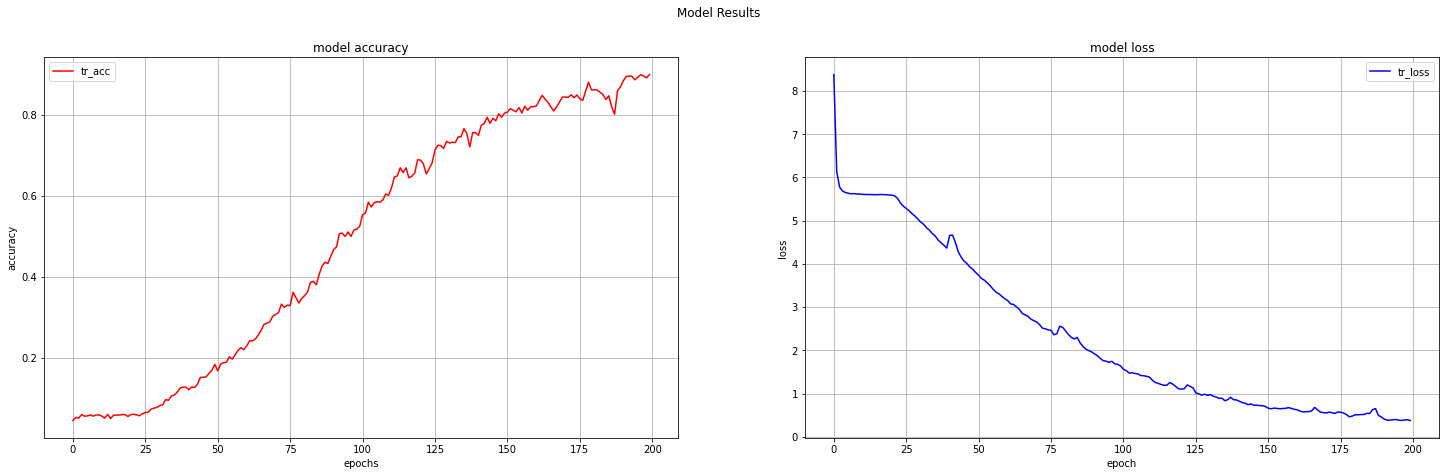

In [ ]:
results_virt(his1)

<h3><center>Generating Text

In [ ]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # yhat = model.predict_classes(encoded, verbose=0)
        yhat=model.predict(encoded) 
        yhat=np.argmax(yhat,axis=1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [ ]:
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50) 
print(generated)

of the visible and intelligible fixed in your mind i have now take a line which has been cut into two unequal parts and divide each of them again in the same proportion and suppose the two main divisions to answer one to the visible and the other to the intelligible

visible sons double is which that sort that sort that the state but be not be be not be be not if a same should may you any should has suffered will will will will will you will will will will you will will will will will you will will


#LSTM Trial #2

In [ ]:
def define_model(vocab_size, inputlength):
    model = Sequential()
    
    model.add(Embedding(vocab_size, 100, input_length=seq_length))
    model.add(LSTM(128,dropout=0.3))
    # model.add(LSTM(64, return_sequences=True,dropout=0.3))
    # model.add(LSTM(100))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model



In [ ]:
model = define_model(vocab_size, seq_length)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 100)           734000    
                                                                 
 lstm_17 (LSTM)              (None, 128)               117248    
                                                                 
 dense_16 (Dense)            (None, 100)               12900     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 7340)              741340    
                                                                 
Total params: 1,605,488
Trainable params: 1,605,488
Non-trainable params: 0
_________________________________________________________________


<h3><center>Training Model

In [ ]:
# model.fit(X, y, batch_size=128, epochs=200, validation_split=0.1)
his1=model.fit(X, y, batch_size=128, epochs=200)

Epoch 1/200
18/18 [==============================] - 3s 32ms/step - loss: 8.6346 - accuracy: 0.0417
Epoch 2/200
18/18 [==============================] - 1s 32ms/step - loss: 6.3054 - accuracy: 0.0530
Epoch 3/200
18/18 [==============================] - 1s 33ms/step - loss: 5.7996 - accuracy: 0.0539
Epoch 4/200
18/18 [==============================] - 1s 31ms/step - loss: 5.6834 - accuracy: 0.0578
Epoch 5/200
18/18 [==============================] - 1s 32ms/step - loss: 5.6365 - accuracy: 0.0573
Epoch 6/200
18/18 [==============================] - 1s 33ms/step - loss: 5.6186 - accuracy: 0.0500
Epoch 7/200
18/18 [==============================] - 1s 34ms/step - loss: 5.5929 - accuracy: 0.0595
Epoch 8/200
18/18 [==============================] - 1s 33ms/step - loss: 5.5709 - accuracy: 0.0526
Epoch 9/200
18/18 [==============================] - 1s 32ms/step - loss: 5.5265 - accuracy: 0.0582
Epoch 10/200
18/18 [==============================] - 1s 32ms/step - loss: 5.4878 - accuracy: 0.0526

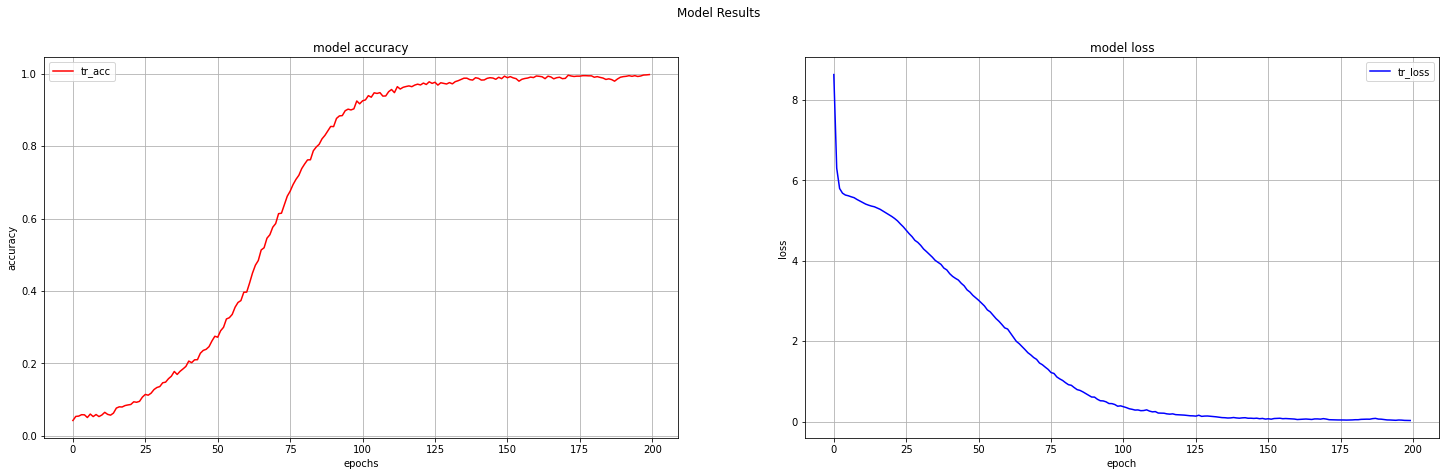

In [ ]:
results_virt(his1)

<h3><center>Generating Text

In [ ]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # yhat = model.predict_classes(encoded, verbose=0)
        yhat=model.predict(encoded) 
        yhat=np.argmax(yhat,axis=1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [ ]:
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50) 
print(generated)

to them short and long quantities also in some cases he appeared to praise or censure the movement of the foot quite as much as the rhythm or perhaps a combination of the two for i am not certain what he meant these matters however as i was saying had better

along as when when justice that i i remember that i our limbs cheat name when justice i i have speak us violate when our evil for when you replied you you rebuked you far comes far comes me comes refrain assuredly assuredly thinks of thus when you you violate


# GRU #1

In [ ]:
def define_model(vocab_size, inputlength):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=seq_length))
    model.add(GRU(100, return_sequences=True,dropout=0.1))
    model.add(GRU(100, return_sequences=True,dropout=0.1))
    model.add(GRU(100))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model



In [ ]:
model = define_model(vocab_size, seq_length)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 100)           734000    
                                                                 
 gru (GRU)                   (None, 50, 100)           60600     
                                                                 
 gru_1 (GRU)                 (None, 50, 100)           60600     
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 7340)             

In [ ]:
his1=model.fit(X, y, batch_size=128, epochs=200)

Epoch 1/200
18/18 [==============================] - 7s 66ms/step - loss: 8.4174 - accuracy: 0.0530
Epoch 2/200
18/18 [==============================] - 1s 65ms/step - loss: 6.0859 - accuracy: 0.0495
Epoch 3/200
18/18 [==============================] - 1s 65ms/step - loss: 5.7701 - accuracy: 0.0547
Epoch 4/200
18/18 [==============================] - 1s 66ms/step - loss: 5.6738 - accuracy: 0.0569
Epoch 5/200
18/18 [==============================] - 1s 65ms/step - loss: 5.6383 - accuracy: 0.0500
Epoch 6/200
18/18 [==============================] - 1s 65ms/step - loss: 5.6291 - accuracy: 0.0573
Epoch 7/200
18/18 [==============================] - 1s 64ms/step - loss: 5.6280 - accuracy: 0.0452
Epoch 8/200
18/18 [==============================] - 1s 65ms/step - loss: 5.6262 - accuracy: 0.0565
Epoch 9/200
18/18 [==============================] - 1s 65ms/step - loss: 5.6203 - accuracy: 0.0582
Epoch 10/200
18/18 [==============================] - 1s 64ms/step - loss: 5.6148 - accuracy: 0.0552

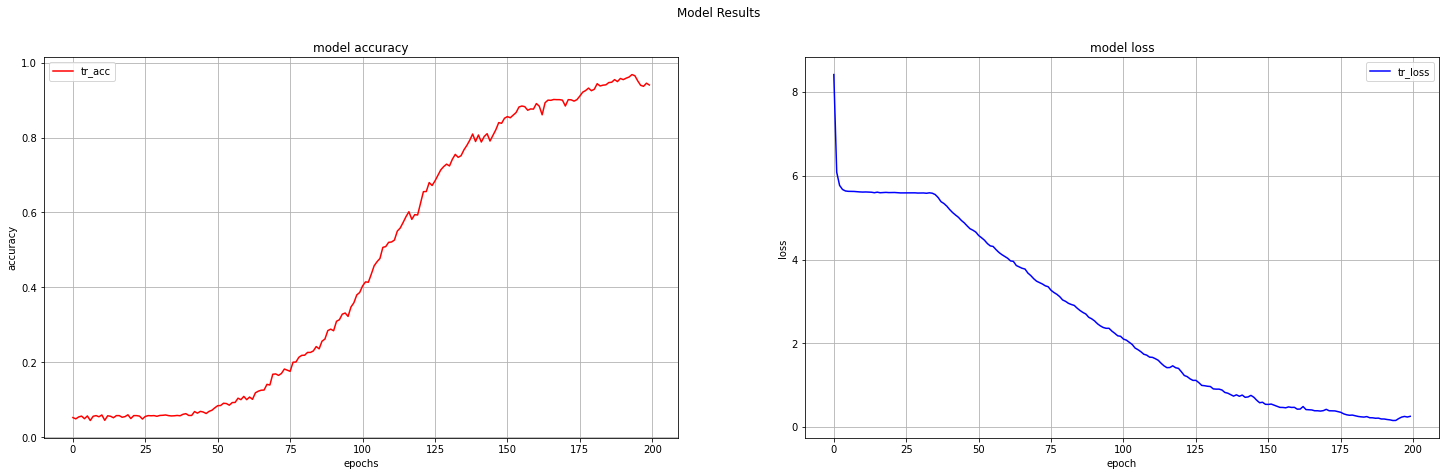

In [ ]:
results_virt(his1)

<h3><center>Generating Text

In [ ]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # yhat = model.predict_classes(encoded, verbose=0)
        yhat=model.predict(encoded) 
        yhat=np.argmax(yhat,axis=1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [ ]:
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50) 
print(generated)

melody to say what these rhythms are will be your must teach me them as you have already taught me the harmonies but indeed he replied i cannot tell you i only know that there are some three principles of rhythm out of which metrical systems are framed just as in

is classes is is is other we other other if if unlike as others case case holds holds other an an an an an an that that he that the that and he he is that man we to to the the the the the the of and the the


# GRU #2

In [ ]:
def define_model(vocab_size, inputlength):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=seq_length))
    model.add(GRU(100,dropout=0.3))
    # model.add(GRU(100, return_sequences=True,dropout=0.1))
    # model.add(GRU(100))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model



In [ ]:
model = define_model(vocab_size, seq_length)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 100)           734000    
                                                                 
 gru_4 (GRU)                 (None, 100)               60600     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 7340)              741340    
                                                                 
Total params: 1,546,040
Trainable params: 1,546,040
Non-trainable params: 0
_________________________________________________________________


In [ ]:
his1=model.fit(X, y, batch_size=128, epochs=125)

Epoch 1/125
18/18 [==============================] - 3s 31ms/step - loss: 8.8580 - accuracy: 0.0443
Epoch 2/125
18/18 [==============================] - 1s 30ms/step - loss: 6.8437 - accuracy: 0.0578
Epoch 3/125
18/18 [==============================] - 1s 30ms/step - loss: 5.8220 - accuracy: 0.0456
Epoch 4/125
18/18 [==============================] - 1s 30ms/step - loss: 5.6760 - accuracy: 0.0534
Epoch 5/125
18/18 [==============================] - 1s 30ms/step - loss: 5.6226 - accuracy: 0.0573
Epoch 6/125
18/18 [==============================] - 1s 30ms/step - loss: 5.6070 - accuracy: 0.0582
Epoch 7/125
18/18 [==============================] - 1s 30ms/step - loss: 5.6032 - accuracy: 0.0595
Epoch 8/125
18/18 [==============================] - 1s 30ms/step - loss: 5.5987 - accuracy: 0.0547
Epoch 9/125
18/18 [==============================] - 1s 29ms/step - loss: 5.5795 - accuracy: 0.0569
Epoch 10/125
18/18 [==============================] - 1s 30ms/step - loss: 5.5350 - accuracy: 0.0547

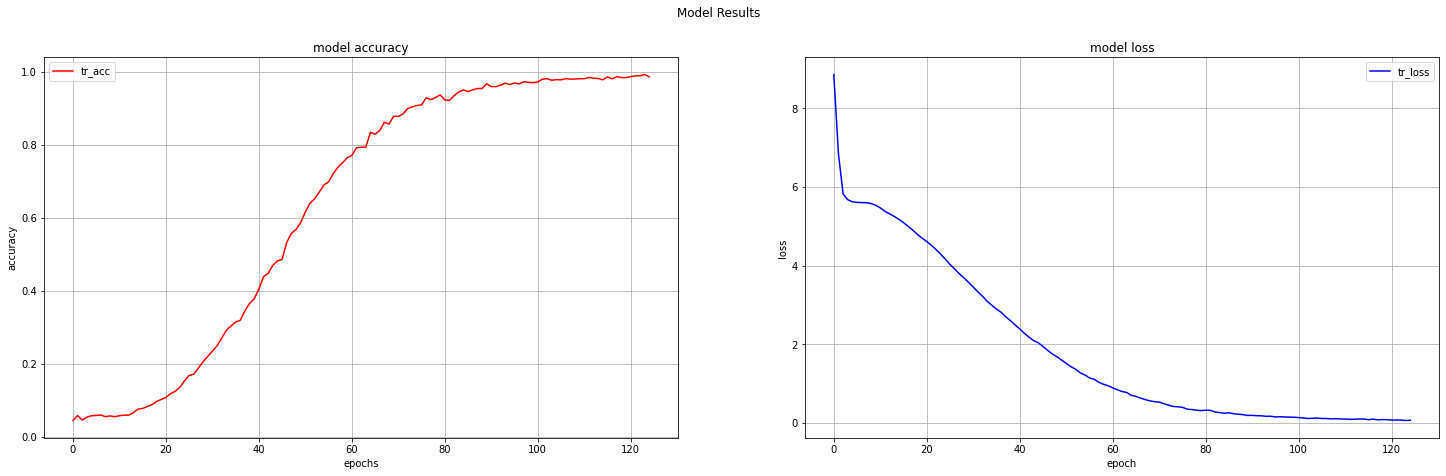

In [ ]:
results_virt(his1)

<h3><center>Generating Text

In [ ]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # yhat = model.predict_classes(encoded, verbose=0)
        yhat=model.predict(encoded) 
        yhat=np.argmax(yhat,axis=1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [ ]:
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50) 
print(generated)

this is right every other is wrong and the evil is one which affects not only the ordering of the state but also the regulation of the individual soul and is exhibited in four forms what are they he said i was proceeding to tell the order in which the four

first of lovers mightiest he said and he said and to the other propose for to this is divine then they have an evil only after contracts when my speaking they say called of what i ought appear put they have been converted prisoner waters waters sprung incapable that we


# SimpleRNN model #1

In [ ]:
def define_model(vocab_size, inputlength):
    model = Sequential()
    
    model.add(Embedding(vocab_size, 100, input_length=seq_length))
    model.add(SimpleRNN(100, return_sequences=True,dropout=0.1))
    model.add(SimpleRNN(100, return_sequences=True,dropout=0.1))
    model.add(SimpleRNN(100))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
model = define_model(vocab_size, seq_length)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 100)           734000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50, 100)           20100     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 50, 100)           20100     
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_30 (Dense)            (None, 100)               10100     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 7340)            

In [ ]:
his1=model.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
18/18 [==============================] - 4s 238ms/step - loss: 2.2757 - accuracy: 0.4487
Epoch 2/100
18/18 [==============================] - 4s 242ms/step - loss: 2.2953 - accuracy: 0.4474
Epoch 3/100
18/18 [==============================] - 4s 245ms/step - loss: 2.5840 - accuracy: 0.3818
Epoch 4/100
18/18 [==============================] - 4s 237ms/step - loss: 2.6040 - accuracy: 0.3736
Epoch 5/100
18/18 [==============================] - 4s 243ms/step - loss: 2.3997 - accuracy: 0.4144
Epoch 6/100
18/18 [==============================] - 4s 249ms/step - loss: 2.2561 - accuracy: 0.4470
Epoch 7/100
18/18 [==============================] - 4s 247ms/step - loss: 2.2116 - accuracy: 0.4652
Epoch 8/100
18/18 [==============================] - 4s 228ms/step - loss: 2.1834 - accuracy: 0.4692
Epoch 9/100
18/18 [==============================] - 4s 231ms/step - loss: 2.1019 - accuracy: 0.4939
Epoch 10/100
18/18 [==============================] - 4s 235ms/step - loss: 2.1057 - accura

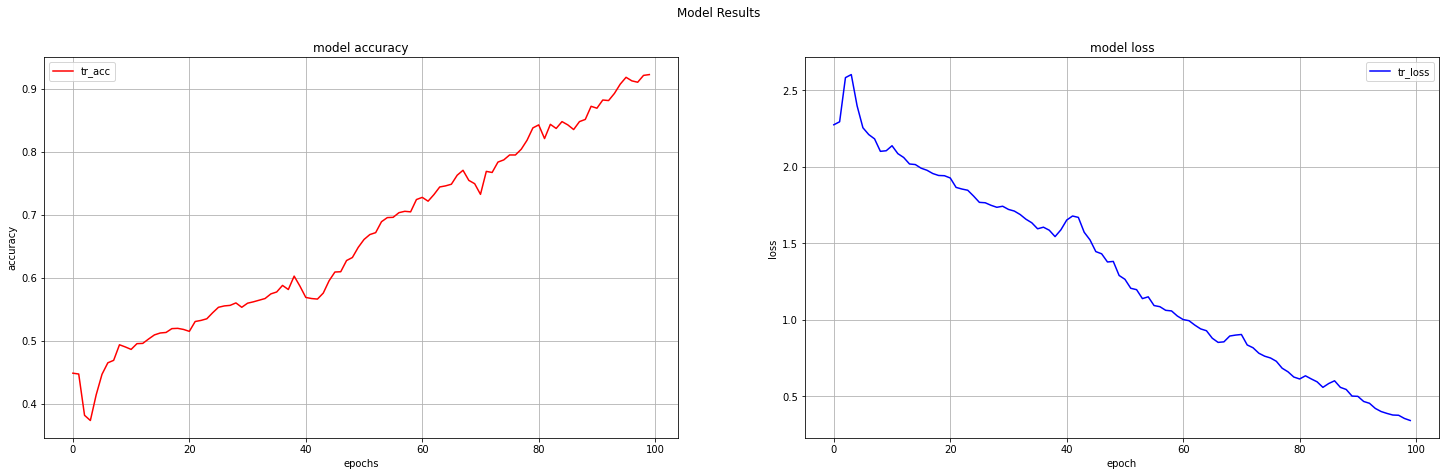

In [ ]:
results_virt(his1)

<h3><center>Generating Text

In [ ]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # yhat = model.predict_classes(encoded, verbose=0)
        yhat=model.predict(encoded) 
        yhat=np.argmax(yhat,axis=1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [ ]:
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50) 
print(generated)

if they could help while they run about at the dionysiac festivals as if they had let out their ears to hear every chorus whether the performance is in town or makes no are there now are we to maintain that all these and any who have similar tastes as well

as as said be out who they if be man as would a his very in the also must have on on only as he he be good said for your as said said he he said are if said be will he would as a them me not said


# SimpleRNN model #2

In [ ]:
def define_model(vocab_size, inputlength):
    model = Sequential()
    
    model.add(Embedding(vocab_size, 100, input_length=seq_length))
    model.add(SimpleRNN(128,dropout=0.3))
    # model.add(SimpleRNN(100, return_sequences=True,dropout=0.1))
    # model.add(SimpleRNN(100))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
model = define_model(vocab_size, seq_length)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 100)           734000    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dense_28 (Dense)            (None, 100)               12900     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 7340)              741340    
                                                                 
Total params: 1,517,552
Trainable params: 1,517,552
Non-trainable params: 0
_________________________________________________________________


In [ ]:
his1=model.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
18/18 [==============================] - 3s 88ms/step - loss: 8.1000 - accuracy: 0.0348
Epoch 2/100
18/18 [==============================] - 2s 90ms/step - loss: 6.0001 - accuracy: 0.0556
Epoch 3/100
18/18 [==============================] - 2s 86ms/step - loss: 5.7351 - accuracy: 0.0526
Epoch 4/100
18/18 [==============================] - 2s 87ms/step - loss: 5.6646 - accuracy: 0.0586
Epoch 5/100
18/18 [==============================] - 2s 86ms/step - loss: 5.6416 - accuracy: 0.0521
Epoch 6/100
18/18 [==============================] - 2s 89ms/step - loss: 5.6366 - accuracy: 0.0556
Epoch 7/100
18/18 [==============================] - 2s 88ms/step - loss: 5.6324 - accuracy: 0.0534
Epoch 8/100
18/18 [==============================] - 2s 90ms/step - loss: 5.6087 - accuracy: 0.0591
Epoch 9/100
18/18 [==============================] - 2s 88ms/step - loss: 5.9081 - accuracy: 0.0517
Epoch 10/100
18/18 [==============================] - 2s 93ms/step - loss: 6.3492 - accuracy: 0.0500

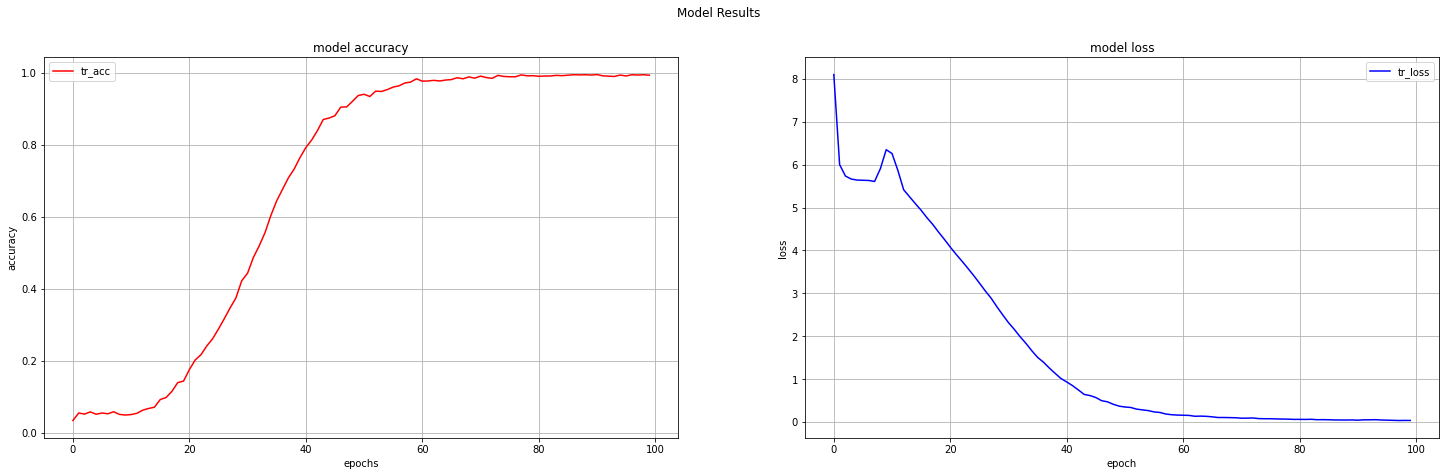

In [ ]:
results_virt(his1)

<h3><center>Generating Text

In [ ]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # yhat = model.predict_classes(encoded, verbose=0)
        yhat=model.predict(encoded) 
        yhat=np.argmax(yhat,axis=1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [ ]:
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50) 
print(generated)

then to the mind when adequately trained we shall be right in handing over the more particular care of the body and in order to avoid prolixity we will now only give the general outlines of the subject very good that they must abstain from intoxication has been already remarked by

speech of his stronger out only general would be had more which but education a good thinks mistaken ideal would hand been happiness the oligarch unlike being any up ground assuredly disease ask attainment to think if he also that we be out which is their state no more you
